In [1]:
import numpy as np
import zipfile as zp
import tensorflow as tf
import tensorflow.keras
import shutil
import os
from PIL import Image
import re
import random
import pickle
import gc
import dill
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Printing number of training and test samples
print('No of training samples  = ' + str(len(os.listdir('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/cats')) + len(os.listdir('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/dogs'))))
print('No of test samples = ' + str(len(os.listdir('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/test'))))
train_fnames = os.listdir('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/cats/') + os.listdir('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/dogs/')

No of training samples  = 20000
No of test samples = 12500


In [ ]:
#Moving training pics to cat/dog subdir based on filename
def move_train_file(path1,path2,x):
   #path specifies either train or test
   #If cat move to cat subdir if not move to dog subdir
    if x[:3] == 'cat':
        shutil.move(path1+'/' +x, path2 + '/cats/'+x)
    elif x[:3] == 'dog':
        shutil.move(path1+'/' +x, path2 + '/dogs/'+x)

pd.Series(train_fnames).apply(lambda x: move_train_file('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train','C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train',x))


In [3]:
print(len(os.listdir('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/cats/')), len(os.listdir('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/dogs/')))

10000 10000


In [25]:
#Randomly pick 20% of training images and move to validation
def move_file(path1,path2,x):
   #path specifies either train or test
   #If cat move to cat subdir if not move to dog subdir
    if x[:3] == 'cat':
        shutil.move(path1+'/cats/' +x, path2 + '/cats/'+x)
    elif x[:3] == 'dog':
        shutil.move(path1 + '/dogs/'+x, path2 + '/dogs/'+x)
valid_fnames_cat = np.array(os.listdir('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/cats'))[np.random.choice(list(range(12500)), 2500, replace=False)]
valid_fnames_dog = np.array(os.listdir('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/dogs'))[np.random.choice(list(range(12500)), 2500, replace=False)]
print(len(valid_fnames_cat), len(valid_fnames_dog))
pd.Series(valid_fnames_cat).apply(lambda x: move_file('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train','C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/validation',x))
pd.Series(valid_fnames_dog).apply(lambda x: move_file('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train','C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/validation',x))
print('Validation set is ',len(os.listdir('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/validation/cats')), ' and ',len(os.listdir('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/validation/dogs')))

2500 2500
Validation set is  2500  and  2500


In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range = 45,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   fill_mode = "nearest"
                                   )
valid_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   horizontal_flip = True,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest',
                                   height_shift_range = 0.2,
                                   width_shift_range = 0.2,
                                   rotation_range = 40
                                   
)

In [4]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import RMSprop, Adam
from keras.regularizers import l2

In [5]:
#Specify the model
model = Sequential()

#Conv layer 1
model.add(Conv2D(32, (3, 3), activation='elu',input_shape=(256,256,3), kernel_initializer='he_normal' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
#Conv layer 2
model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
#Conv layer 3
model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
#Conv layer 4
model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
#Conv layer 5
model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
#Conv layer 6
model.add(Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
#Flatten
model.add(Flatten())
#Fully Connected layer
model.add(Dense(1024, activation='elu', kernel_regularizer=l2(0.001), kernel_initializer='he_normal'))
model.add(BatchNormalization())
#Dropout
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001), kernel_initializer='glorot_normal'))


In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("C:/Users/Muaaz/dogs-vs-cats-classifier-3.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

my_callback_es = EarlyStopping(patience = 5, 
                               restore_best_weights = True
                               )

my_callback_rlr = ReduceLROnPlateau(monitor='val_accuracy', 
                                    patience=3, 
                                    factor=0.5, 
                                    min_lr=0.00001, 
                                    verbose=1
                                    )

model.compile(optimizer = RMSprop(learning_rate=0.0005), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy']
             )

In [8]:
batchsize = 32
history = model.fit(train_datagen.flow_from_directory('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/', 
                                                      batch_size = batchsize,
                                                      target_size=(256, 256),
                                                     class_mode = 'binary'),
                    validation_data = valid_datagen.flow_from_directory('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/validation/',
                                                     batch_size = batchsize,
                                                     target_size = (256,256),
                                                     class_mode = 'binary'),
                    steps_per_epoch = len(train_fnames)/10/batchsize,
                    callbacks = [my_callback_es , my_callback_rlr, checkpoint],
                    epochs = 70
                   )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/70
63/62 [==============================] - ETA: -1s - loss: 3.1374 - accuracy: 0.5754
Epoch 00001: val_loss improved from inf to 4.75603, saving model to C:/Users/Muaaz\dogs-vs-cats-classifier-3.h5
63/62 [==============================] - 336s 5s/step - loss: 3.1374 - accuracy: 0.5754 - val_loss: 4.7560 - val_accuracy: 0.4934
Epoch 2/70
63/62 [==============================] - ETA: -1s - loss: 2.8533 - accuracy: 0.5962
Epoch 00002: val_loss improved from 4.75603 to 2.88608, saving model to C:/Users/Muaaz\dogs-vs-cats-classifier-3.h5
63/62 [==============================] - 320s 5s/step - loss: 2.8533 - accuracy: 0.5962 - val_loss: 2.8861 - val_accuracy: 0.5428
Epoch 3/70
63/62 [==============================] - ETA: -1s - loss: 2.6154 - accuracy: 0.6096
Epoch 00003: val_loss did not improve from 2.88608
63/62 [==============================] - 328s 5s/step - loss: 2.6154 - accuracy: 0.6096 - v

Epoch 25/70
63/62 [==============================] - ETA: -1s - loss: 0.7494 - accuracy: 0.7644
Epoch 00025: val_loss improved from 0.67399 to 0.65785, saving model to C:/Users/Muaaz\dogs-vs-cats-classifier-3.h5
63/62 [==============================] - 316s 5s/step - loss: 0.7494 - accuracy: 0.7644 - val_loss: 0.6579 - val_accuracy: 0.8204
Epoch 26/70
63/62 [==============================] - ETA: -1s - loss: 0.7203 - accuracy: 0.7852
Epoch 00026: val_loss improved from 0.65785 to 0.64865, saving model to C:/Users/Muaaz\dogs-vs-cats-classifier-3.h5
63/62 [==============================] - 335s 5s/step - loss: 0.7203 - accuracy: 0.7852 - val_loss: 0.6486 - val_accuracy: 0.8198
Epoch 27/70
63/62 [==============================] - ETA: -1s - loss: 0.6640 - accuracy: 0.8160
Epoch 00027: val_loss did not improve from 0.64865
63/62 [==============================] - 343s 5s/step - loss: 0.6640 - accuracy: 0.8160 - val_loss: 0.6858 - val_accuracy: 0.8030
Epoch 28/70
63/62 [====================

In [ ]:
score = model.evaluate(verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

[]

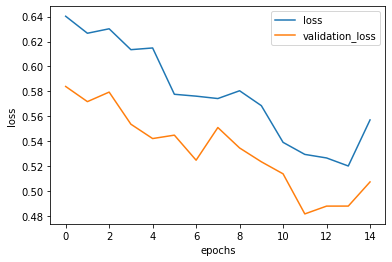

In [57]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.plot()

[]

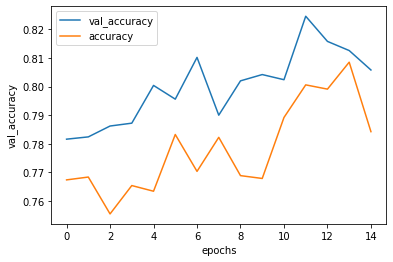

In [59]:
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.legend()
plt.plot()

In [7]:
model.load_weights("C:/Users/Muaaz/dogs-vs-cats-classifier-3.h5")

In [13]:
batchsize = 32
history = model.fit(train_datagen.flow_from_directory('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/', 
                                                      batch_size = batchsize,
                                                      target_size=(256, 256),
                                                     class_mode = 'binary'),
                    validation_data = valid_datagen.flow_from_directory('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/validation/',
                                                     batch_size = batchsize,
                                                     target_size = (256,256),
                                                     class_mode = 'binary'),
                    steps_per_epoch = len(train_fnames)/10/batchsize,
                    callbacks = [my_callback_es , my_callback_rlr, checkpoint],
                    epochs = 10
                   )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/10
63/62 [==============================] - ETA: -1s - loss: 0.4124 - accuracy: 0.8383
Epoch 00001: val_loss improved from inf to 0.40139, saving model to C:/Users/Muaaz\dogs-vs-cats-classifier-3.h5
63/62 [==============================] - 340s 5s/step - loss: 0.4124 - accuracy: 0.8383 - val_loss: 0.4014 - val_accuracy: 0.8332
Epoch 2/10
63/62 [==============================] - ETA: -1s - loss: 0.3813 - accuracy: 0.8527
Epoch 00002: val_loss improved from 0.40139 to 0.36129, saving model to C:/Users/Muaaz\dogs-vs-cats-classifier-3.h5
63/62 [==============================] - 316s 5s/step - loss: 0.3813 - accuracy: 0.8527 - val_loss: 0.3613 - val_accuracy: 0.8602
Epoch 3/10
63/62 [==============================] - ETA: -1s - loss: 0.3407 - accuracy: 0.8636
Epoch 00003: val_loss did not improve from 0.36129
63/62 [==============================] - 317s 5s/step - loss: 0.3407 - accuracy: 0.8636 - v

In [9]:
model.save('C:/Users/Muaaz/dogs-vs-cats-classifier-3.h5')

In [10]:
model.load_weights("C:/Users/Muaaz/dogs-vs-cats-classifier-3.h5")

In [11]:
batchsize = 32
history = model.fit(train_datagen.flow_from_directory('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/', 
                                                      batch_size = batchsize,
                                                      target_size=(256, 256),
                                                     class_mode = 'binary'),
                    validation_data = valid_datagen.flow_from_directory('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/validation/',
                                                     batch_size = batchsize,
                                                     target_size = (256,256),
                                                     class_mode = 'binary'),
                    steps_per_epoch = len(train_fnames)/10/batchsize,
                    callbacks = [my_callback_es , my_callback_rlr, checkpoint],
                    epochs = 20
                   )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/20
63/62 [==============================] - ETA: -1s - loss: 0.2549 - accuracy: 0.9033
Epoch 00001: val_loss did not improve from 0.22408
63/62 [==============================] - 317s 5s/step - loss: 0.2549 - accuracy: 0.9033 - val_loss: 0.2381 - val_accuracy: 0.9108
Epoch 2/20
63/62 [==============================] - ETA: -1s - loss: 0.2535 - accuracy: 0.9033
Epoch 00002: val_loss did not improve from 0.22408
63/62 [==============================] - 317s 5s/step - loss: 0.2535 - accuracy: 0.9033 - val_loss: 0.2242 - val_accuracy: 0.9124
Epoch 3/20
63/62 [==============================] - ETA: -1s - loss: 0.2399 - accuracy: 0.9087
Epoch 00003: val_loss improved from 0.22408 to 0.20030, saving model to C:/Users/Muaaz\dogs-vs-cats-classifier-3.h5
63/62 [==============================] - 315s 5s/step - loss: 0.2399 - accuracy: 0.9087 - val_loss: 0.2003 - val_accuracy: 0.9256
Epoch 4/20
63/62 [====

In [16]:
model.save('C:/Users/Muaaz/dogs-vs-cats-classifier-3.h5')

In [13]:
model.load_weights("C:/Users/Muaaz/dogs-vs-cats-classifier-3.h5")

In [15]:
batchsize = 32
history = model.fit(train_datagen.flow_from_directory('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/train/', 
                                                      batch_size = batchsize,
                                                      target_size=(256, 256),
                                                     class_mode = 'binary'),
                    validation_data = valid_datagen.flow_from_directory('C:/Users/Muaaz/dogs-vs-cats-redux-kernels-edition/validation/',
                                                     batch_size = batchsize,
                                                     target_size = (256,256),
                                                     class_mode = 'binary'),
                    steps_per_epoch = len(train_fnames)/10/batchsize,
                    callbacks = [my_callback_es , my_callback_rlr, checkpoint],
                    epochs = 10
                   )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/10
63/62 [==============================] - ETA: -1s - loss: 0.1885 - accuracy: 0.9191
Epoch 00001: val_loss did not improve from 0.17231
63/62 [==============================] - 318s 5s/step - loss: 0.1885 - accuracy: 0.9191 - val_loss: 0.1729 - val_accuracy: 0.9378
Epoch 2/10
63/62 [==============================] - ETA: -1s - loss: 0.2269 - accuracy: 0.9132
Epoch 00002: val_loss did not improve from 0.17231
63/62 [==============================] - 320s 5s/step - loss: 0.2269 - accuracy: 0.9132 - val_loss: 0.1731 - val_accuracy: 0.9390
Epoch 3/10
63/62 [==============================] - ETA: -1s - loss: 0.2022 - accuracy: 0.9291
Epoch 00003: val_loss did not improve from 0.17231
63/62 [==============================] - 319s 5s/step - loss: 0.2022 - accuracy: 0.9291 - val_loss: 0.1764 - val_accuracy: 0.9366
Epoch 4/10
63/62 [==============================] - ETA: -1s - loss: 0.1747 - accuracy:

[]

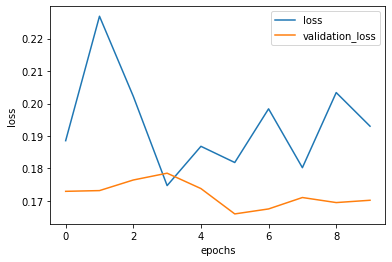

In [17]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.plot()

[]

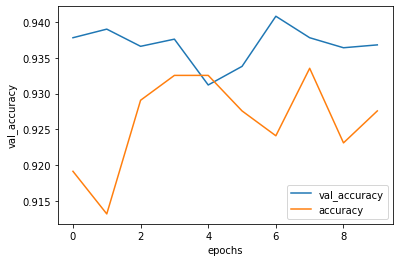

In [18]:
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.legend()
plt.plot()